In [1]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:\Work_with_MM")

# Verify the change
print(os.getcwd())

H:\Work_with_MM


Processed 00_001: KGE = 0.2078
Processed 00_002: KGE = -0.7519
Processed 00_003: KGE = -0.1575
Processed 00_004: KGE = -0.0338
Processed 00_005: KGE = 0.0385
Processed 00_006: KGE = 0.3938
Processed 00_007: KGE = -1.6601
Processed 00_008: KGE = 0.0696
Processed 00_009: KGE = 0.0256
Processed 00_010: KGE = -2.3339
Processed 00_011: KGE = -0.8477
Processed 00_012: KGE = -0.9199
Processed 00_013: KGE = -0.8176
Processed 00_014: KGE = -1.7678
Processed 00_015: KGE = -0.5559
Processed 00_016: KGE = 0.0955
Processed 00_017: KGE = 0.2327
Processed 00_018: KGE = -1.3162
Processed 00_019: KGE = -1.1263
Processed 00_020: KGE = -1.2527
Processed 00_021: KGE = -0.8853
Processed 00_022: KGE = -2.2899
Processed 00_023: KGE = -0.3123
Processed 00_024: KGE = -0.1386
Processed 00_025: KGE = -0.0452
Processed 00_026: KGE = -1.2691
Processed 00_027: KGE = 0.3493
Processed 00_028: KGE = 0.0374
Processed 00_029: KGE = 0.0042
Processed 00_030: KGE = -0.5605
Processed 00_031: KGE = 0.2863
Processed 00_032: K

[19:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 5375/5377 [00:37<00:00]        

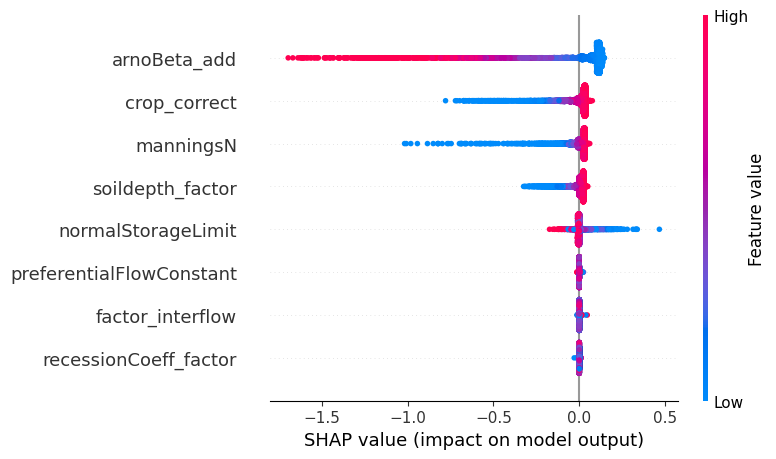

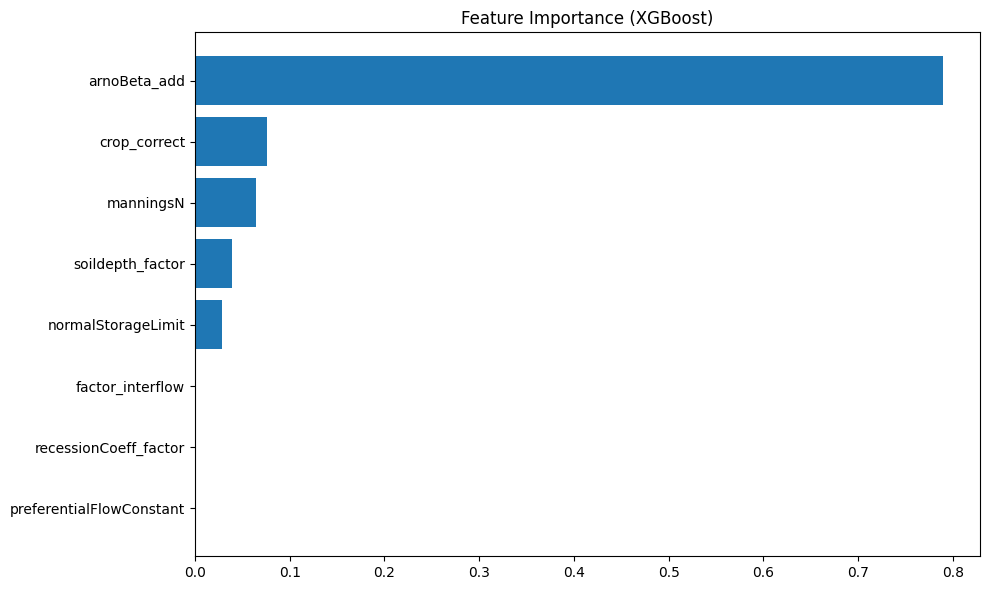


KGE Statistics:
Min: -3.3009
Max: 0.5949
Mean: 0.3375
Std: 0.4627


In [19]:
import os
import configparser
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# ---------- 1. تابع محاسبه KGE ----------
def calc_kge(sim, obs):
    sim, obs = np.array(sim), np.array(obs)
    cc = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# ---------- 2. آدرس‌ها ----------
base_dir = r"H:\Work_with_MM\CWatM_modified\Toolkit\Calibration\runs_calibration3"
obs_file = r"H:\Work_with_MM\Data_GCM\Daily_Dis_Observation.csv"

# ---------- 3. داده‌های مشاهداتی ----------
obs = pd.read_csv(obs_file, parse_dates=True, index_col=0)
obs = obs["discharge"].values  # فرض: ستون discharge

# ---------- 4. خواندن نتایج هر ران ----------
params_list = []
kge_list = []

for run_dir in os.listdir(base_dir):
    run_path = os.path.join(base_dir, run_dir)
    if not os.path.isdir(run_path):
        continue

    # فایل ini - با چک کردن وجود فایل
    ini_file_candidate1 = os.path.join(run_path, f"settings_CWatM_template-Run{run_dir}.ini")
    ini_file_candidate2 = os.path.join(run_path, "calibration.ini")
    
    ini_file = None
    if os.path.exists(ini_file_candidate1):
        ini_file = ini_file_candidate1
    elif os.path.exists(ini_file_candidate2):
        ini_file = ini_file_candidate2
    else:
        print(f"INI file not found in {run_dir}")
        continue

    config = configparser.ConfigParser()
    config.read(ini_file)

    # پارامترها
    try:
        params = {
            "crop_correct": float(config.get("CALIBRATION", "crop_correct")),
            "soildepth_factor": float(config.get("CALIBRATION", "soildepth_factor")),
            "preferentialFlowConstant": float(config.get("CALIBRATION", "preferentialFlowConstant")),
            "arnoBeta_add": float(config.get("CALIBRATION", "arnoBeta_add")),
            "factor_interflow": float(config.get("CALIBRATION", "factor_interflow")),
            "recessionCoeff_factor": float(config.get("CALIBRATION", "recessionCoeff_factor")),
            "manningsN": float(config.get("CALIBRATION", "manningsN")),
            "normalStorageLimit": float(config.get("CALIBRATION", "normalStorageLimit")),
        }
    except (configparser.NoSectionError, configparser.NoOptionError) as e:
        print(f"Error reading parameters from {ini_file}: {e}")
        continue

    # خروجی شبیه‌سازی (tss)
    tss_file = os.path.join(run_path, "discharge_daily.tss")
    if not os.path.exists(tss_file):
        print(f"TSS file not found: {tss_file}")
        continue

    try:
        # خواندن فایل TSS - روش ساده‌تر و مطمئن‌تر
        # داده‌ها از خط 5 شروع می‌شوند (همانطور که از خروجی دیباگ مشخص است)
        sim = pd.read_csv(tss_file, sep=r'\s+', skiprows=4, header=None, engine='python')
        
        # ستون دوم داده‌های دبی است
        if sim.shape[1] >= 2:
            sim = sim[1].values
        else:
            print(f"Not enough columns in {tss_file}")
            continue

        # حذف مقادیر NaN یا inf
        sim = sim[np.isfinite(sim)]
        
        if len(sim) == 0:
            print(f"No valid data in {tss_file}")
            continue

        # طول داده‌ها را هماهنگ کن
        n = min(len(sim), len(obs))
        if n == 0:
            print(f"No overlapping data in {tss_file}")
            continue
            
        kge = calc_kge(sim[:n], obs[:n])

        params_list.append(params)
        kge_list.append(kge)
        print(f"Processed {run_dir}: KGE = {kge:.4f}")
        
    except Exception as e:
        print(f"Error processing {run_dir}: {e}")
        continue

# ---------- 5. ساخت دیتافریم ----------
if len(params_list) == 0:
    print("No valid data found! Check your file paths and structure.")
    exit()

X = pd.DataFrame(params_list)
y = np.array(kge_list)

print("X shape:", X.shape)
print("y shape:", y.shape)
print(f"Number of successful runs: {len(params_list)}")

if len(params_list) < 2:
    print("Need at least 2 successful runs for modeling")
    exit()

# ---------- 6. مدل ML ----------
model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X, y)

# ---------- 7. SHAP ----------
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# نمودار کلی
shap.summary_plot(shap_values, X)

# نمایش اهمیت ویژگی‌ها
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# نمایش برخی آمار
print(f"\nKGE Statistics:")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")

Processed 00_001: KGE = 0.2078
Processed 00_002: KGE = -0.7519
Processed 00_003: KGE = -0.1575
Processed 00_004: KGE = -0.0338
Processed 00_005: KGE = 0.0385
Processed 00_006: KGE = 0.3938
Processed 00_007: KGE = -1.6601
Processed 00_008: KGE = 0.0696
Processed 00_009: KGE = 0.0256
Processed 00_010: KGE = -2.3339
Processed 00_011: KGE = -0.8477
Processed 00_012: KGE = -0.9199
Processed 00_013: KGE = -0.8176
Processed 00_014: KGE = -1.7678
Processed 00_015: KGE = -0.5559
Processed 00_016: KGE = 0.0955
Processed 00_017: KGE = 0.2327
Processed 00_018: KGE = -1.3162
Processed 00_019: KGE = -1.1263
Processed 00_020: KGE = -1.2527
Processed 00_021: KGE = -0.8853
Processed 00_022: KGE = -2.2899
Processed 00_023: KGE = -0.3123
Processed 00_024: KGE = -0.1386
Processed 00_025: KGE = -0.0452
Processed 00_026: KGE = -1.2691
Processed 00_027: KGE = 0.3493
Processed 00_028: KGE = 0.0374
Processed 00_029: KGE = 0.0042
Processed 00_030: KGE = -0.5605
Processed 00_031: KGE = 0.2863
Processed 00_032: K

[19:26:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 5367/5377 [00:45<00:00]        

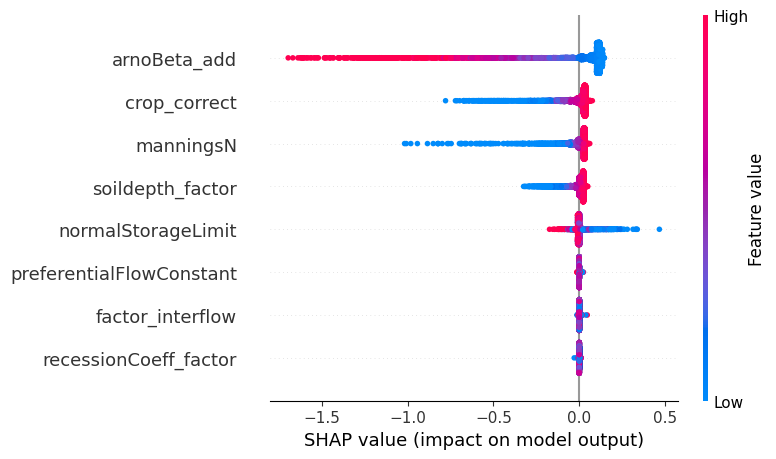

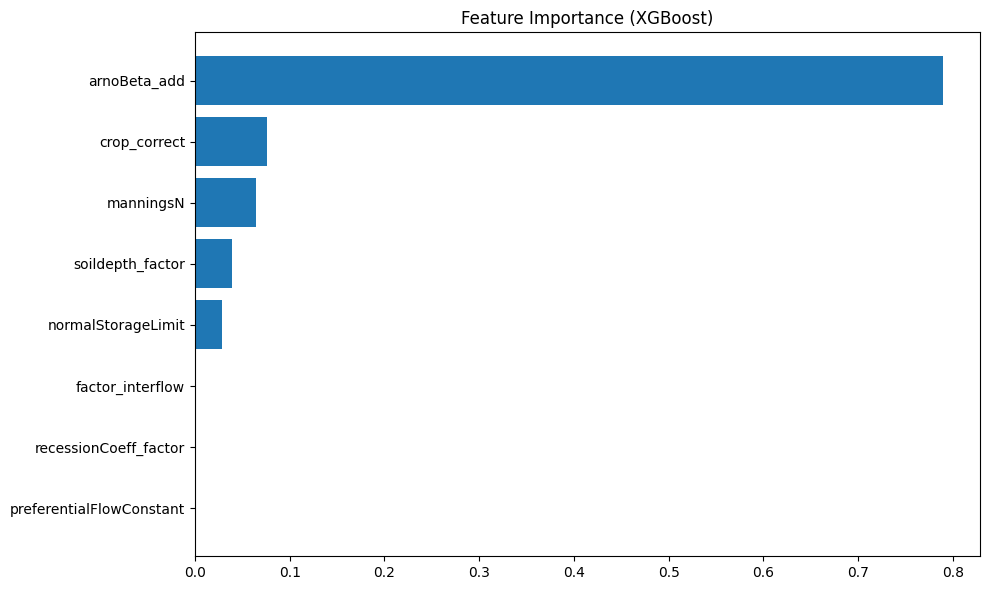


KGE Statistics:
Min: -3.3009
Max: 0.5949
Mean: 0.3375
Std: 0.4627
Could not add feature importance to Excel: [Errno 13] Permission denied: 'H:\\Work_with_MM\\KGE_7Prameters.xlsx'


In [20]:
import os
import configparser
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# ---------- 1. تابع محاسبه KGE ----------
def calc_kge(sim, obs):
    sim, obs = np.array(sim), np.array(obs)
    cc = np.corrcoef(sim, obs)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = np.mean(sim) / np.mean(obs)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

# ---------- 2. آدرس‌ها ----------
base_dir = r"H:\Work_with_MM\CWatM_modified\Toolkit\Calibration\runs_calibration3"
obs_file = r"H:\Work_with_MM\Data_GCM\Daily_Dis_Observation.csv"
output_excel = r"H:\Work_with_MM\KGE_7Prameters.xlsx"  # فایل خروجی اکسل

# ---------- 3. داده‌های مشاهداتی ----------
obs = pd.read_csv(obs_file, parse_dates=True, index_col=0)
obs = obs["discharge"].values  # فرض: ستون discharge

# ---------- 4. خواندن نتایج هر ران ----------
params_list = []
kge_list = []
run_names = []  # برای ذخیره نام ران‌ها

for run_dir in os.listdir(base_dir):
    run_path = os.path.join(base_dir, run_dir)
    if not os.path.isdir(run_path):
        continue

    # فایل ini - با چک کردن وجود فایل
    ini_file_candidate1 = os.path.join(run_path, f"settings_CWatM_template-Run{run_dir}.ini")
    ini_file_candidate2 = os.path.join(run_path, "calibration.ini")
    
    ini_file = None
    if os.path.exists(ini_file_candidate1):
        ini_file = ini_file_candidate1
    elif os.path.exists(ini_file_candidate2):
        ini_file = ini_file_candidate2
    else:
        print(f"INI file not found in {run_dir}")
        continue

    config = configparser.ConfigParser()
    config.read(ini_file)

    # پارامترها
    try:
        params = {
            "crop_correct": float(config.get("CALIBRATION", "crop_correct")),
            "soildepth_factor": float(config.get("CALIBRATION", "soildepth_factor")),
            "preferentialFlowConstant": float(config.get("CALIBRATION", "preferentialFlowConstant")),
            "arnoBeta_add": float(config.get("CALIBRATION", "arnoBeta_add")),
            "factor_interflow": float(config.get("CALIBRATION", "factor_interflow")),
            "recessionCoeff_factor": float(config.get("CALIBRATION", "recessionCoeff_factor")),
            "manningsN": float(config.get("CALIBRATION", "manningsN")),
            "normalStorageLimit": float(config.get("CALIBRATION", "normalStorageLimit")),
        }
    except (configparser.NoSectionError, configparser.NoOptionError) as e:
        print(f"Error reading parameters from {ini_file}: {e}")
        continue

    # خروجی شبیه‌سازی (tss)
    tss_file = os.path.join(run_path, "discharge_daily.tss")
    if not os.path.exists(tss_file):
        print(f"TSS file not found: {tss_file}")
        continue

    try:
        # خواندن فایل TSS - روش ساده‌تر و مطمئن‌تر
        # داده‌ها از خط 5 شروع می‌شوند (همانطور که از خروجی دیباگ مشخص است)
        sim = pd.read_csv(tss_file, sep=r'\s+', skiprows=4, header=None, engine='python')
        
        # ستون دوم داده‌های دبی است
        if sim.shape[1] >= 2:
            sim = sim[1].values
        else:
            print(f"Not enough columns in {tss_file}")
            continue

        # حذف مقادیر NaN یا inf
        sim = sim[np.isfinite(sim)]
        
        if len(sim) == 0:
            print(f"No valid data in {tss_file}")
            continue

        # طول داده‌ها را هماهنگ کن
        n = min(len(sim), len(obs))
        if n == 0:
            print(f"No overlapping data in {tss_file}")
            continue
            
        kge = calc_kge(sim[:n], obs[:n])

        params_list.append(params)
        kge_list.append(kge)
        run_names.append(run_dir)  # ذخیره نام ران
        print(f"Processed {run_dir}: KGE = {kge:.4f}")
        
    except Exception as e:
        print(f"Error processing {run_dir}: {e}")
        continue

# ---------- 5. ساخت دیتافریم ----------
if len(params_list) == 0:
    print("No valid data found! Check your file paths and structure.")
    exit()

X = pd.DataFrame(params_list)
y = np.array(kge_list)

# اضافه کردن نام ران و KGE به دیتافریم X
X['run_name'] = run_names
X['KGE'] = y

print("X shape:", X.shape)
print("y shape:", y.shape)
print(f"Number of successful runs: {len(params_list)}")

# ---------- 6. ذخیره در فایل اکسل ----------
try:
    # ایجاد یک ExcelWriter برای ذخیره چندین sheet
    with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
        # ذخیره داده‌های کامل (X + y)
        X.to_excel(writer, sheet_name='All_Data', index=False)
        
        # ذخیره فقط پارامترها (X)
        X_params = X.drop(['run_name', 'KGE'], axis=1)
        X_params.to_excel(writer, sheet_name='Parameters', index=False)
        
        # ذخیره KGE ها (y)
        kge_df = pd.DataFrame({
            'run_name': run_names,
            'KGE': y
        })
        kge_df.to_excel(writer, sheet_name='KGE_Values', index=False)
        
        # ذخیره آمار توصیفی
        stats_df = pd.DataFrame({
            'Statistic': ['Count', 'Mean', 'Std', 'Min', 'Max', '25%', '50%', '75%'],
            'KGE': [
                len(y),
                np.mean(y),
                np.std(y),
                np.min(y),
                np.max(y),
                np.percentile(y, 25),
                np.percentile(y, 50),
                np.percentile(y, 75)
            ]
        })
        stats_df.to_excel(writer, sheet_name='Statistics', index=False)
        
        # ذخیره همبستگی بین پارامترها و KGE
        correlation_data = []
        for param in X_params.columns:
            corr = np.corrcoef(X_params[param], y)[0, 1]
            correlation_data.append({'Parameter': param, 'Correlation_with_KGE': corr})
        
        corr_df = pd.DataFrame(correlation_data)
        corr_df.to_excel(writer, sheet_name='Correlations', index=False)
    
    print(f"\nData successfully saved to: {output_excel}")
    print("Sheets created:")
    print("  - All_Data: Complete dataset with parameters and KGE values")
    print("  - Parameters: Only the calibration parameters")
    print("  - KGE_Values: Run names and their KGE values")
    print("  - Statistics: Descriptive statistics of KGE values")
    print("  - Correlations: Correlation between parameters and KGE")
    
except Exception as e:
    print(f"Error saving to Excel file: {e}")
    # ذخیره ساده‌تر در صورت خطا
    try:
        simple_output = output_excel.replace('.xlsx', '_simple.xlsx')
        X.to_excel(simple_output, index=False)
        print(f"Simple data saved to: {simple_output}")
    except Exception as e2:
        print(f"Could not save any Excel file: {e2}")

# ---------- 7. مدل ML (اگر داده کافی وجود دارد) ----------
if len(params_list) < 2:
    print("Need at least 2 successful runs for modeling")
    exit()

model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_params, y)

# ---------- 8. SHAP ----------
explainer = shap.Explainer(model, X_params)
shap_values = explainer(X_params)

# نمودار کلی
shap.summary_plot(shap_values, X_params)

# نمایش اهمیت ویژگی‌ها
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': X_params.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# نمایش برخی آمار
print(f"\nKGE Statistics:")
print(f"Min: {y.min():.4f}")
print(f"Max: {y.max():.4f}")
print(f"Mean: {y.mean():.4f}")
print(f"Std: {y.std():.4f}")

# ذخیره اهمیت ویژگی‌ها در اکسل
try:
    # باز کردن فایل موجود و اضافه کردن sheet جدید
    with pd.ExcelWriter(output_excel, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        feature_importance.to_excel(writer, sheet_name='Feature_Importance', index=False)
    print("Feature importance saved to Excel file")
except Exception as e:
    print(f"Could not add feature importance to Excel: {e}")

Data loaded successfully from Excel file
Data shape: (5377, 10)
Columns: ['crop_correct', 'soildepth_factor', 'preferentialFlowConstant', 'arnoBeta_add', 'factor_interflow', 'recessionCoeff_factor', 'manningsN', 'normalStorageLimit', 'run_name', 'KGE']

First 5 rows of data:
   crop_correct  soildepth_factor  preferentialFlowConstant  arnoBeta_add  \
0      1.235751          1.281048                  6.859113      0.108474   
1      1.576541          0.875025                  4.500981      0.891433   
2      1.486260          1.291231                  5.768497      0.401101   
3      0.916324          1.317238                  7.205576      0.016206   
4      1.510463          1.222929                  2.038560      0.246717   

   factor_interflow  recessionCoeff_factor  manningsN  normalStorageLimit  \
0          1.086829               5.598648   7.436221            0.295064   
1          2.189699               9.337311   9.928568            0.385947   
2          1.730831           

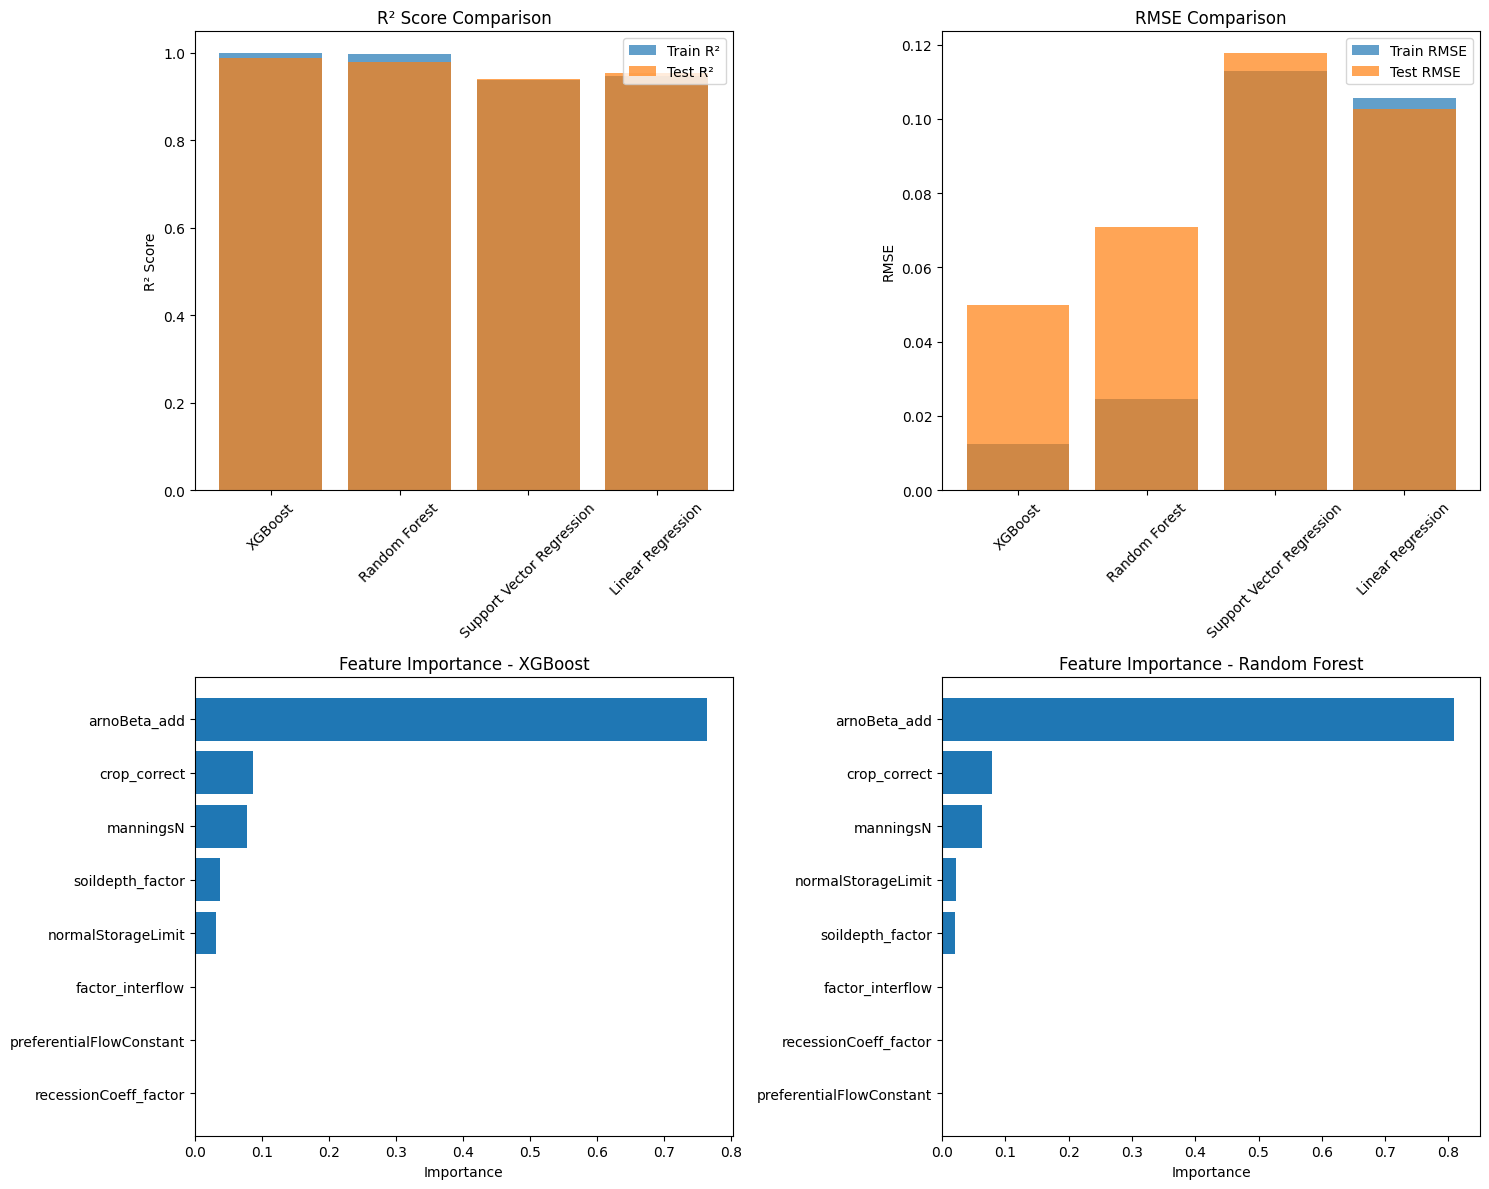


SHAP ANALYSIS

Generating SHAP analysis for XGBoost...


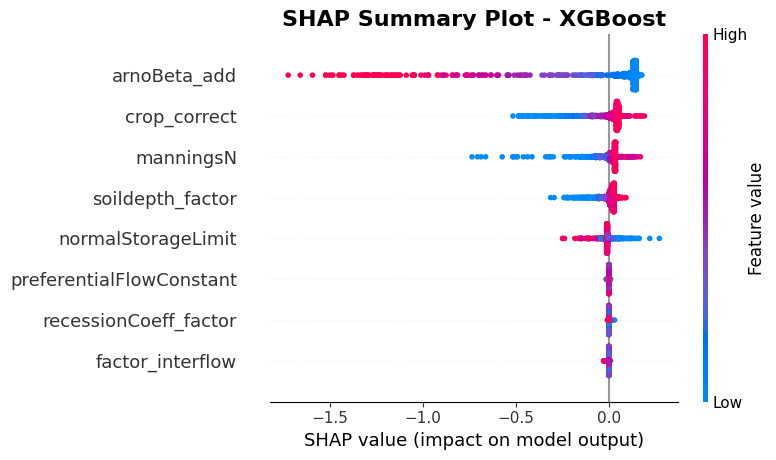

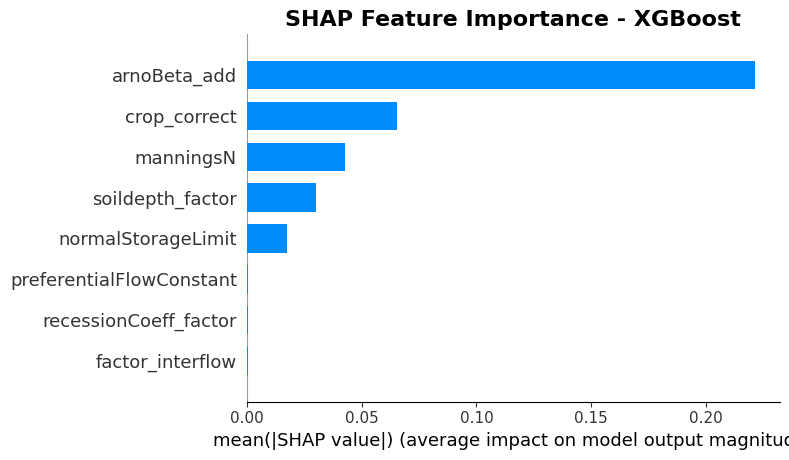

SHAP analysis completed for XGBoost

Generating SHAP analysis for Random Forest...


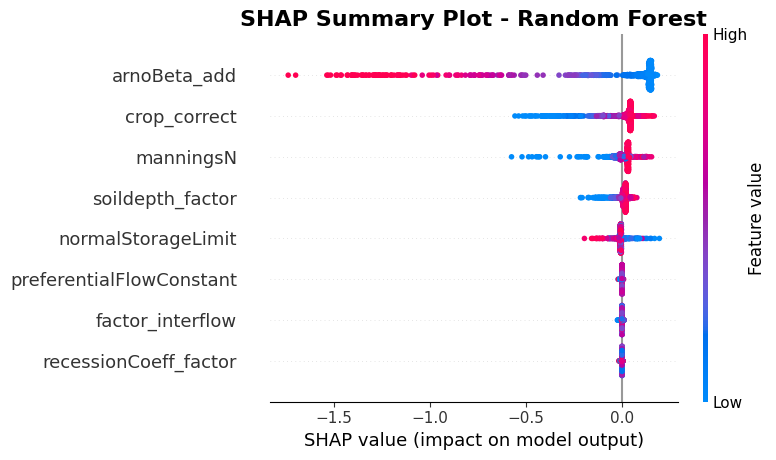

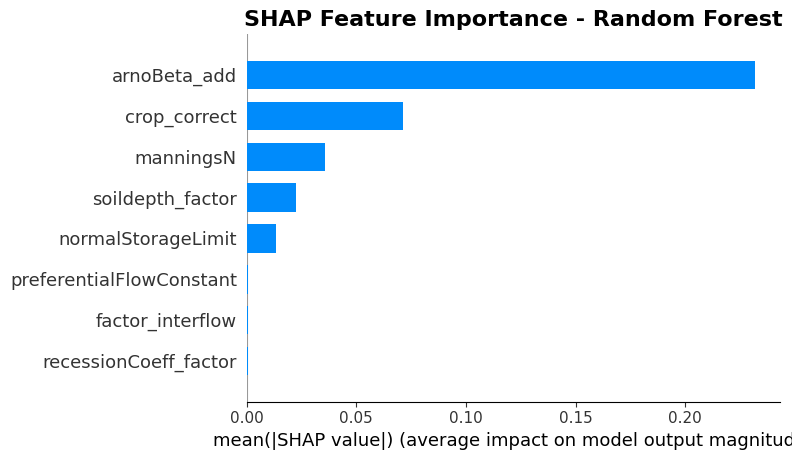

SHAP analysis completed for Random Forest

Generating SHAP analysis for Support Vector Regression...


Using 4301 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1076 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
import os
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------- 1. خواندن داده‌ها از فایل اکسل ----------
excel_file = r"H:\Work_with_MM\KGE_7Prameters.xlsx"

try:
    # خواندن داده‌ها از فایل اکسل
    df = pd.read_excel(excel_file)
    print("Data loaded successfully from Excel file")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # بررسی ساختار داده‌ها
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # جدا کردن ویژگی‌ها (X) و هدف (y)
    # فرض می‌کنیم ستون KGE یا هدف آخرین ستون است یا مشخص کنید کدام ستون است
    if 'KGE' in df.columns:
        y = df['KGE'].values
        X = df.drop('KGE', axis=1)
    else:
        # اگر ستون KGE وجود ندارد، فرض می‌کنیم آخرین ستون هدف است
        y = df.iloc[:, -1].values
        X = df.iloc[:, :-1]
    
    # حذف ستون‌های غیرعددی (مانند نام ران)
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_columns]
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Features: {X.columns.tolist()}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    exit()

# ---------- 2. تقسیم داده‌ها به train و test ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ---------- 3. تعریف مدل‌ها ----------
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale'),
    'Linear Regression': LinearRegression()
}

# ---------- 4. آموزش مدل‌ها و ارزیابی ----------
results = {}
trained_models = {}

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # آموزش مدل
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # پیش‌بینی
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # محاسبه معیارهای ارزیابی
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'model': model
    }
    
    print(f"{name}:")
    print(f"  Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"  Test R²:  {test_r2:.4f}, Test RMSE:  {test_rmse:.4f}")

# ---------- 5. مقایسه مدل‌ها ----------
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_R2': [results[name]['train_r2'] for name in results],
    'Test_R2': [results[name]['test_r2'] for name in results],
    'Train_RMSE': [results[name]['train_rmse'] for name in results],
    'Test_RMSE': [results[name]['test_rmse'] for name in results]
})

print(comparison_df.round(4))

# نمودار مقایسه مدل‌ها
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² scores
axes[0, 0].bar(comparison_df['Model'], comparison_df['Train_R2'], alpha=0.7, label='Train R²')
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test_R2'], alpha=0.7, label='Test R²')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE scores
axes[0, 1].bar(comparison_df['Model'], comparison_df['Train_RMSE'], alpha=0.7, label='Train RMSE')
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test_RMSE'], alpha=0.7, label='Test RMSE')
axes[0, 1].set_title('RMSE Comparison')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# اهمیت ویژگی‌ها برای مدل‌های درختی
tree_models = ['XGBoost', 'Random Forest']
for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            axes[1, i].barh(feature_importance_df['feature'], feature_importance_df['importance'])
            axes[1, i].set_title(f'Feature Importance - {model_name}')
            axes[1, i].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# ---------- 6. تحلیل SHAP برای مدل‌ها ----------
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# ایجاد نمودارهای SHAP برای هر مدل
for name, model in trained_models.items():
    print(f"\nGenerating SHAP analysis for {name}...")
    
    try:
        # برای مدل‌های مختلف از روش‌های مختلف SHAP استفاده می‌کنیم
        if name == 'Linear Regression':
            # برای رگرسیون خطی از LinearExplainer استفاده می‌کنیم
            explainer = shap.LinearExplainer(model, X_train)
        elif name == 'Support Vector Regression':
            # برای SVR از KernelExplainer استفاده می‌کنیم
            explainer = shap.KernelExplainer(model.predict, X_train)
        else:
            # برای مدل‌های درختی از TreeExplainer استفاده می‌کنیم
            explainer = shap.TreeExplainer(model)
        
        # محاسبه مقادیر SHAP
        shap_values = explainer.shap_values(X_test)
        
        # نمودار خلاصه SHAP
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # نمودار بار (bar plot)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"SHAP analysis completed for {name}")
        
    except Exception as e:
        print(f"Error in SHAP analysis for {name}: {e}")

# ---------- 7. ذخیره نتایج ----------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

output_file = r"H:\Work_with_MM\Model_Comparison_Results.xlsx"

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # ذخیره داده‌های اصلی
        df.to_excel(writer, sheet_name='Original_Data', index=False)
        
        # ذخیره نتایج مقایسه مدل‌ها
        comparison_df.to_excel(writer, sheet_name='Model_Comparison', index=False)
        
        # ذخیره اهمیت ویژگی‌ها برای مدل‌های درختی
        for model_name in tree_models:
            if model_name in trained_models and hasattr(trained_models[model_name], 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': trained_models[model_name].feature_importances_
                }).sort_values('Importance', ascending=False)
                importance_df.to_excel(writer, sheet_name=f'{model_name}_Importance', index=False)
        
        # ذخیره پیش‌بینی‌ها
        predictions_df = pd.DataFrame({
            'Actual': y_test
        })
        for name in trained_models:
            predictions_df[f'{name}_Predicted'] = trained_models[name].predict(X_test)
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
    
    print(f"Results successfully saved to: {output_file}")
    
except Exception as e:
    print(f"Error saving results to Excel: {e}")

# ---------- 8. گزارش نهایی ----------
print("\n" + "="*50)
print("FINAL REPORT")
print("="*50)

best_model = comparison_df.loc[comparison_df['Test_R2'].idxmax()]
print(f"Best model: {best_model['Model']} (Test R²: {best_model['Test_R2']:.4f})")

print("\nModel Performance Ranking (by Test R²):")
ranked_models = comparison_df.sort_values('Test_R2', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    print(f"{i}. {row['Model']}: R² = {row['Test_R2']:.4f}, RMSE = {row['Test_RMSE']:.4f}")

print(f"\nAnalysis completed! Check the generated plots and Excel file:")
print(f"Excel file: {output_file}")

In [ ]:
import os
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------- 1. خواندن داده‌ها از فایل اکسل ----------
excel_file = r"H:\Work_with_MM\KGE_7Prameters.xlsx"

try:
    # خواندن داده‌ها از فایل اکسل
    df = pd.read_excel(excel_file)
    print("Data loaded successfully from Excel file")
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # بررسی ساختار داده‌ها
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # جدا کردن ویژگی‌ها (X) و هدف (y)
    if 'KGE' in df.columns:
        y = df['KGE'].values
        X = df.drop('KGE', axis=1)
    else:
        # اگر ستون KGE وجود ندارد، فرض می‌کنیم آخرین ستون هدف است
        y = df.iloc[:, -1].values
        X = df.iloc[:, :-1]
    
    # حذف ستون‌های غیرعددی (مانند نام ران)
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_columns]
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Features: {X.columns.tolist()}")
    
except Exception as e:
    print(f"Error reading Excel file: {e}")
    exit()

# ---------- 2. تقسیم داده‌ها به train و test ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# ---------- 3. تعریف 5 مدل ----------
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42)
}

# ---------- 4. آموزش مدل‌ها و ارزیابی ----------
results = {}
trained_models = {}

print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # آموزش مدل
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # پیش‌بینی
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # محاسبه معیارهای ارزیابی
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'model': model
    }
    
    print(f"{name}:")
    print(f"  Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}")
    print(f"  Test R²:  {test_r2:.4f}, Test RMSE:  {test_rmse:.4f}")

# ---------- 5. مقایسه مدل‌ها ----------
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_R2': [results[name]['train_r2'] for name in results],
    'Test_R2': [results[name]['test_r2'] for name in results],
    'Train_RMSE': [results[name]['train_rmse'] for name in results],
    'Test_RMSE': [results[name]['test_rmse'] for name in results]
})

print(comparison_df.round(4))

# نمودار مقایسه مدل‌ها
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# R² scores
bars1 = axes[0, 0].bar(comparison_df['Model'], comparison_df['Train_R2'], alpha=0.7, label='Train R²', color=colors)
bars2 = axes[0, 0].bar(comparison_df['Model'], comparison_df['Test_R2'], alpha=0.7, label='Test R²', color=colors)
axes[0, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# اضافه کردن مقادیر روی نمودار
for bar, value in zip(bars1, comparison_df['Train_R2']):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', 
                   ha='center', va='bottom', fontsize=9)

# RMSE scores
bars3 = axes[0, 1].bar(comparison_df['Model'], comparison_df['Train_RMSE'], alpha=0.7, label='Train RMSE', color=colors)
bars4 = axes[0, 1].bar(comparison_df['Model'], comparison_df['Test_RMSE'], alpha=0.7, label='Test RMSE', color=colors)
axes[0, 1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# اهمیت ویژگی‌ها برای مدل‌های درختی
tree_models = ['XGBoost', 'Random Forest', 'Gradient Boosting']
for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            axes[1, i].barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                           color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df))))
            axes[1, i].set_title(f'Feature Importance - {model_name}', fontsize=12, fontweight='bold')
            axes[1, i].set_xlabel('Importance')

# ضرایب رگرسیون خطی و Ridge
regression_models = ['Linear Regression', 'Ridge Regression']
for i, model_name in enumerate(regression_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        coefficients = pd.DataFrame({
            'feature': X.columns,
            'coefficient': model.coef_
        }).sort_values('coefficient', key=abs, ascending=True)
        
        axes[1, 3+i].barh(coefficients['feature'], coefficients['coefficient'], 
                         color=plt.cm.plasma(np.linspace(0, 1, len(coefficients))))
        axes[1, 3+i].set_title(f'{model_name} Coefficients', fontsize=12, fontweight='bold')
        axes[1, 3+i].set_xlabel('Coefficient Value')
        axes[1, 3+i].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# ---------- 6. تحلیل SHAP برای مدل‌ها ----------
print("\n" + "="*50)
print("SHAP ANALYSIS")
print("="*50)

# ایجاد نمودارهای SHAP برای هر مدل
for name, model in trained_models.items():
    print(f"\nGenerating SHAP analysis for {name}...")
    
    try:
        # برای مدل‌های مختلف از روش‌های مختلف SHAP استفاده می‌کنیم
        if name in ['Linear Regression', 'Ridge Regression']:
            # برای رگرسیون خطی از LinearExplainer استفاده می‌کنیم
            explainer = shap.LinearExplainer(model, X_train)
            shap_values = explainer.shap_values(X_test)
        else:
            # برای مدل‌های درختی از TreeExplainer استفاده می‌کنیم
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        
        # نمودار خلاصه SHAP
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # نمودار بار (bar plot)
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # محاسبه میانگین مقادیر مطلق SHAP
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Mean |SHAP|': mean_abs_shap
        }).sort_values('Mean |SHAP|', ascending=False)
        
        print(f"SHAP Feature Importance for {name}:")
        print(shap_importance_df.round(4))
        
        print(f"✅ SHAP analysis completed for {name}")
        
    except Exception as e:
        print(f"❌ Error in SHAP analysis for {name}: {e}")

# ---------- 7. تحلیل پیش‌بینی‌ها ----------
print("\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)

# نمودار پیش‌بینی‌ها در مقابل مقادیر واقعی
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(trained_models.items()):
    if idx < len(axes):
        y_pred = model.predict(X_test)
        
        axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f'{name}\nR² = {results[name]["test_r2"]:.4f}', fontweight='bold')
        
        # اضافه کردن خط R² به نمودار
        axes[idx].text(0.05, 0.95, f'R² = {results[name]["test_r2"]:.4f}', 
                      transform=axes[idx].transAxes, fontsize=11,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# حذف محورهای اضافی
for idx in range(len(trained_models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# ---------- 8. تحلیل رتبه‌بندی ویژگی‌ها ----------
print("\n" + "="*50)
print("FEATURE RANKING ANALYSIS")
print("="*50)

# ترکیب اهمیت ویژگی‌ها از تمام مدل‌ها
feature_ranking = {}

for name, model in trained_models.items():
    if name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            for i, feature in enumerate(X.columns):
                if feature not in feature_ranking:
                    feature_ranking[feature] = []
                feature_ranking[feature].append(importance[i])
    elif name in ['Linear Regression', 'Ridge Regression']:
        coefficients = np.abs(model.coef_)
        for i, feature in enumerate(X.columns):
            if feature not in feature_ranking:
                feature_ranking[feature] = []
            feature_ranking[feature].append(coefficients[i])

# محاسبه میانگین رتبه
feature_avg_importance = {}
for feature, importances in feature_ranking.items():
    feature_avg_importance[feature] = np.mean(importances)

# ایجاد دیتافریم رتبه‌بندی
feature_rank_df = pd.DataFrame({
    'Feature': list(feature_avg_importance.keys()),
    'Average_Importance': list(feature_avg_importance.values())
}).sort_values('Average_Importance', ascending=False)

print("Overall Feature Ranking (Average across all models):")
print(feature_rank_df.round(4))

# نمودار رتبه‌بندی کلی ویژگی‌ها
plt.figure(figsize=(10, 6))
plt.barh(feature_rank_df['Feature'], feature_rank_df['Average_Importance'], 
         color=plt.cm.coolwarm(np.linspace(0, 1, len(feature_rank_df))))
plt.xlabel('Average Importance Score')
plt.title('Overall Feature Importance Ranking\n(Averaged across all 5 models)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ---------- 9. ذخیره نتایج ----------
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

output_file = r"H:\Work_with_MM\Model_Comparison_Results.xlsx"

try:
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        # ذخیره داده‌های اصلی
        df.to_excel(writer, sheet_name='Original_Data', index=False)
        
        # ذخیره نتایج مقایسه مدل‌ها
        comparison_df.to_excel(writer, sheet_name='Model_Comparison', index=False)
        
        # ذخیره اهمیت ویژگی‌ها برای مدل‌های درختی
        for model_name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
            if model_name in trained_models and hasattr(trained_models[model_name], 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': trained_models[model_name].feature_importances_
                }).sort_values('Importance', ascending=False)
                importance_df.to_excel(writer, sheet_name=f'{model_name}_Importance', index=False)
        
        # ذخیره ضرایب رگرسیون
        for model_name in ['Linear Regression', 'Ridge Regression']:
            if model_name in trained_models:
                coeff_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Coefficient': trained_models[model_name].coef_,
                    'Absolute_Coefficient': np.abs(trained_models[model_name].coef_)
                }).sort_values('Absolute_Coefficient', ascending=False)
                coeff_df.to_excel(writer, sheet_name=f'{model_name}_Coefficients', index=False)
        
        # ذخیره پیش‌بینی‌ها
        predictions_df = pd.DataFrame({
            'Actual': y_test
        })
        for name in trained_models:
            predictions_df[f'{name}_Predicted'] = trained_models[name].predict(X_test)
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)
        
        # ذخیره رتبه‌بندی کلی ویژگی‌ها
        feature_rank_df.to_excel(writer, sheet_name='Overall_Feature_Ranking', index=False)
        
        # ذخیره مقادیر SHAP
        for name in trained_models:
            try:
                if name in ['Linear Regression', 'Ridge Regression']:
                    explainer = shap.LinearExplainer(trained_models[name], X_train)
                    shap_values = explainer.shap_values(X_test)
                else:
                    explainer = shap.TreeExplainer(trained_models[name])
                    shap_values = explainer.shap_values(X_test)
                
                shap_df = pd.DataFrame(shap_values, columns=[f'{col}_SHAP' for col in X.columns])
                shap_df.to_excel(writer, sheet_name=f'{name}_SHAP_Values', index=False)
                
            except Exception as e:
                print(f"Could not save SHAP values for {name}: {e}")
    
    print(f"✅ Results successfully saved to: {output_file}")
    print("\n📊 Sheets created in the Excel file:")
    print("  - Original_Data: Original dataset")
    print("  - Model_Comparison: Performance metrics for all models")
    print("  - [Model]_Importance: Feature importance for tree-based models")
    print("  - [Model]_Coefficients: Coefficients for regression models")
    print("  - Predictions: Actual vs predicted values for test set")
    print("  - Overall_Feature_Ranking: Combined feature ranking")
    print("  - [Model]_SHAP_Values: SHAP values for each model")
    
except Exception as e:
    print(f"❌ Error saving results to Excel: {e}")

# ---------- 10. گزارش نهایی ----------
print("\n" + "="*50)
print("FINAL REPORT")
print("="*50)

best_model = comparison_df.loc[comparison_df['Test_R2'].idxmax()]
print(f"🏆 Best model: {best_model['Model']} (Test R²: {best_model['Test_R2']:.4f})")

print("\n📈 Model Performance Ranking (by Test R²):")
ranked_models = comparison_df.sort_values('Test_R2', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"{medal} {i}. {row['Model']}: R² = {row['Test_R2']:.4f}, RMSE = {row['Test_RMSE']:.4f}")

print(f"\n✅ Analysis completed!")
print(f"📁 Results saved to: {output_file}")
print(f"🤖 {len(trained_models)} models trained and evaluated")
print(f"🔍 SHAP analysis generated for all models")
print(f"📊 Overall feature ranking calculated")